# Forward Reachability Analysis


In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

Observe forward reachability analysis for two agents, one being a double the other a single integrator. Since both agent types are intrinsically isotropic agents, i.e. they are assumed to be able to switch the direction of a control input instantly, the boundary of the (forward) reachable sets should be circles.

In [2]:
import torch
from mantrap.agents import *

In [3]:
agent = DoubleIntegratorDTAgent(position=torch.zeros(2), velocity=torch.tensor([2, 3]))
boundary_double = agent.reachability_boundary(time_steps=5, dt=1.0)

In [4]:
agent = IntegratorDTAgent(position=torch.zeros(2), velocity=torch.tensor([2, 3]))
boundary_single = agent.reachability_boundary(time_steps=5, dt=1.0)

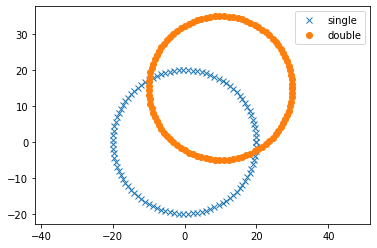

In [5]:
boundary_double_samples = boundary_double.samples().detach().numpy()
boundary_single_samples = boundary_single.samples().detach().numpy()

plt.plot(boundary_single_samples[:, 0], boundary_single_samples[:, 1], 'x', label="single")
plt.plot(boundary_double_samples[:, 0], boundary_double_samples[:, 1], 'o', label="double")
plt.axis('equal')
plt.legend()
plt.show()

Now we want to show the correctness of this analytically determined boundaries using a numerical simulation, in which we basically simulate trajectories, by always using maximal control inputs in at least one direction. Here we use the double integrator, the method can be applied similarly with the single integrator (by just switching the class initialization `DoubleIntegratorDTAgent` with `IntegratorDTAgent`.

In [7]:
agent = DoubleIntegratorDTAgent(position=torch.zeros(2), velocity=torch.zeros(2))

num_samples, time_steps, dt = 200, 5, 1.0
control_min, control_max = agent.control_limits()
control_samples = torch.linspace(start=control_min, end=control_max, steps=num_samples)

## Analytical solution.
boundary_double = agent.reachability_boundary(time_steps=time_steps, dt=dt)
boundary_double_samples = boundary_double.samples().detach().numpy()

## Numerical solution
def _compute_end_points(control_x: float, control_y: float) -> torch.Tensor:
    controls = torch.ones((time_steps, 2)).__mul__(torch.tensor([control_x, control_y]))
    controls = agent.make_controls_feasible(controls)
    return agent.unroll_trajectory(controls=controls, dt=dt)[-1, 0:2]

# Compute the forward reachability bounds numerically by integrating trajectories at the bound
# of feasible control inputs, i.e. since 2D: (x, y_max), (x, y_min), (x_max, y), (x_min, y).
boundary_numeric = torch.zeros((4*num_samples, 2))
for i, control_sample in enumerate(control_samples):
    boundary_numeric[i + 0*num_samples, :] = _compute_end_points(control_sample, control_max)
    boundary_numeric[i + 1*num_samples, :] = _compute_end_points(control_sample, control_min)
    boundary_numeric[i + 2*num_samples, :] = _compute_end_points(control_max, control_sample)
    boundary_numeric[i + 3*num_samples, :] = _compute_end_points(control_min, control_sample)
    
# Derive numeric bounds properties. This is not sufficient proof for being a circle but at
# least a necessary condition.
min_x, min_y = min(boundary_numeric[:, 0]), min(boundary_numeric[:, 1])
max_x, max_y = max(boundary_numeric[:, 0]), max(boundary_numeric[:, 1])
radius_numeric = (max_x - min_x) / 2
center_numeric = torch.tensor([min_x + radius_numeric, min_y + radius_numeric])

print(f"Center: analytic = {boundary_double.center}, numerical = {center_numeric}")
print(f"Radius: analytic = {boundary_double.radius}, numerical = {radius_numeric}")

Center: analytic = tensor([0., 0.]), numerical = tensor([0., 0.])
Radius: analytic = 20.0, numerical = 19.99974822998047


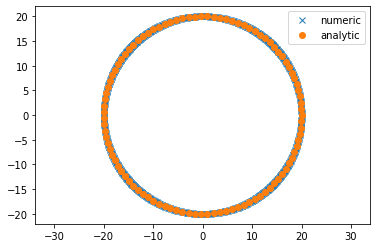

In [8]:
plt.plot(boundary_numeric[:, 0], boundary_numeric[:, 1], 'x', label="numeric")
plt.plot(boundary_double_samples[:, 0], boundary_double_samples[:, 1], 'o', label="analytic")
plt.axis('equal')
plt.legend()
plt.show()